# SDE - Heston model

## Contents
   - [Heston model](#sec2)
      - [Distribution of log-returns](#sec2.1)
   - [Characteristic function](#sec3)
      - [Option pricing](#sec3.1)

In [22]:
import numpy as np
import scipy as scp
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.special as scps
from statsmodels.graphics.gofplots import qqplot
from scipy.linalg import cholesky
from functools import partial
from scipy.optimize import minimize
from heston import Heston_paths
from heston import Heston_paths_log
import All_functions_for_risk as risk
%run 'All_functions_for_risk.py'
from IPython.display import display
import sympy

sympy.init_printing()


def display_matrix(m):
    display(sympy.Matrix(m))

/Users/rutzzz/Risk Management/All_functions_for_risk.py:34: DeprecationWarning: Please use `LinAlgError` from the `scipy.linalg` namespace, the `scipy.linalg.misc` namespace is deprecated.
  from scipy.linalg.misc import LinAlgError


# Heston Model

The Heston model is a mathematical model describing the evolution of the price of a financial asset, in which the volatility of the asset price is itself a stochastic process. The model is defined by the following stochastic differential equations (SDE):

$$
\begin{align}
dS_t &= \mu S_t \, dt + \sqrt{v_t} S_t \, dW^1_t, \\
dv_t &= \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW^2_t,
\end{align}
$$

where:
- $S_t$ is the price of the asset at time $t$,
- $v_t$ is the variance of the asset price at time $t$,
- $\mu$ is the drift rate of the asset price,
- $\kappa$ is the mean-reversion rate of the variance,
- $\theta$ is the long-term mean of the variance,
- $\sigma$ is the volatility of the variance,
- $dW^1_t$ and $dW^2_t$ are Wiener processes with correlation $\rho$, i.e., $dW^1_t \, dW^2_t = \rho \, dt$.

The Heston model is often used in the field of financial mathematics to model the dynamics of asset prices, particularly for options pricing. One of the key features of the Heston model is its ability to capture the "smile" effect observed in the implied volatility of options.

The model also requires that the Feller condition $2\kappa\theta > \sigma^2$ is satisfied to ensure that the variance process remains positive.

For more information on the Cox-Ingersoll-Ross (CIR) process, which is related to the variance process in the Heston model, refer to notebook **1.2**.


### Path Generation

The Heston process can be discretized using the Euler-Maruyama method, as proposed in notebook **2.1**.

In this example, we prefer to use the logarithmic variables $X_t = \log(S_t)$ and $Y_t = \log(v_t)$ in order to avoid negative values for the variance process $\{v_t\}_{t\geq 0}$. The discretized equations are as follows:

$$
\begin{align}
dX_t &= \left( \mu - \frac{1}{2} e^{Y_t} \right) dt + e^{Y_t/2} dW^1_t, \\
dY_t &= e^{-Y_t} \left[ \kappa (\theta - e^{Y_t}) - \frac{1}{2}\sigma^2 \right] dt + \sigma e^{-Y_t/2} dW^2_t.
\end{align}
$$

This choice of using logarithmic variables is arbitrary. 

**Comment:**         
From a theoretical perspective, using logarithmic variables is the best choice because it avoids negative values without any modification of the original process.     
From a practical point of view, it is better not to use logarithmic variables!    
The reason is that the algorithm can produce NaNs or overflows when the time steps are not small enough (e.g., for $N < 20000$). This happens quite frequently.


In [26]:
%%time
np.random.seed(seed=42)

N = 1000000  # time steps
paths = 3  # number of paths
T = 1
T_vec, dt = np.linspace(0, T, N, retstep=True)
dt_sq = np.sqrt(dt)

S0 = 100  # spot price
X0 = np.log(S0)  # log price
v0 = 0.04  # spot variance
Y0 = np.log(v0)  # log-variance

mu = 0.1  # drift
rho = -0.2  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term variance
sigma = 0.3  # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt(theta * sigma**2 / (2 * kappa))  # asymptotic standard deviation for the CIR process
assert 2 * kappa * theta > sigma**2  # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs(mean=MU, cov=COV, size=(N - 1, paths))
W_S = W[:, :, 0]  # Stock Brownian motion:     W_1
W_v = W[:, :, 1]  # Variance Brownian motion:  W_2

# Initialize vectors
Y = np.zeros((N, paths))
Y[0, :] = Y0
X = np.zeros((N, paths))
X[0, :] = X0
v = np.zeros(N)

# Generate paths
for t in range(0, N - 1):
    v = np.exp(Y[t, :])  # variance
    v_sq = np.sqrt(v)  # square root of variance

    Y[t + 1, :] = (
        Y[t, :] + (1 / v) * (kappa * (theta - v) - 0.5 * sigma**2) * dt + sigma * (1 / v_sq) * dt_sq * W_v[t, :]
    )
    X[t + 1, :] = X[t, :] + (mu - 0.5 * v) * dt + v_sq * dt_sq * W_S[t, :]

CPU times: user 18.2 s, sys: 243 ms, total: 18.4 s
Wall time: 17.1 s


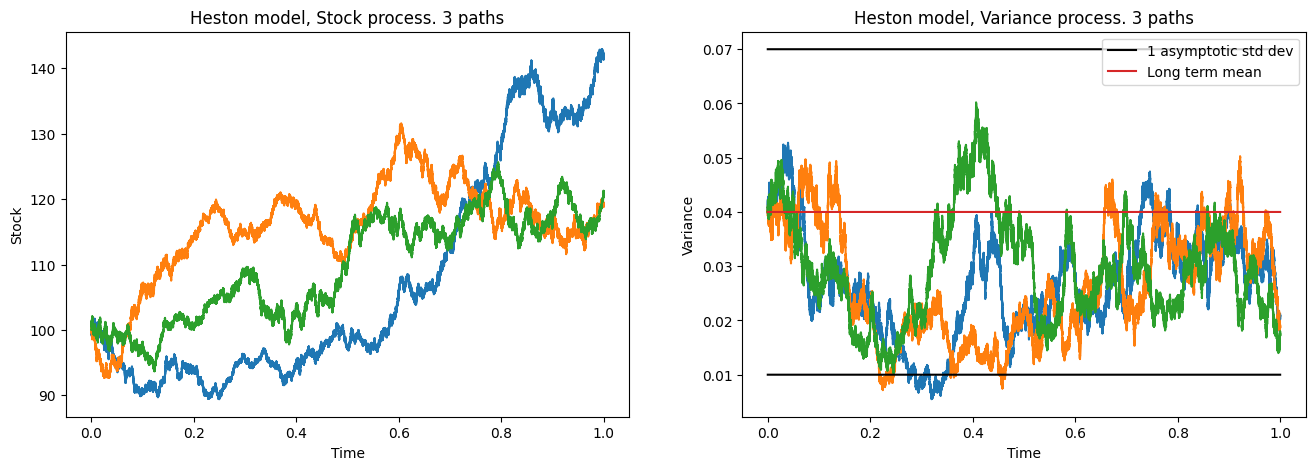

In [27]:
fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X))
ax1.set_title("Heston model, Stock process. 3 paths")
ax1.set_xlabel("Time")
ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y))
ax2.set_title("Heston model, Variance process. 3 paths")
ax2.set_xlabel("Time")
ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy) * np.ones_like(T_vec), label="1 asymptotic std dev", color="black")
ax2.plot(T_vec, (theta - std_asy) * np.ones_like(T_vec), color="black")
ax2.plot(T_vec, theta * np.ones_like(T_vec), label="Long term mean")
ax2.legend(loc="upper right")
plt.show()

<a id='sec2.1'></a>
# Distribution of Log-Returns

The Python code presented above is very slow when we want to generate a large number of paths.    
For this reason, it has been implemented in Cython. 

### CYTHON Implementation

1) The function `Heston_paths_log` contains the code presented above, but translated into Cython.      
   The code returns only the "good" paths, meaning that if there are overflows, they are ignored.     
   Since this method returns a random number of paths, it is preferable to use the next method.

2) The function `Heston_paths` implements the discretization of the original process $(S_t,v_t)_{t\geq 0}$.
   The Cox-Ingersoll-Ross (CIR) process is discretized using method (4) presented in notebook **1.2**, i.e., by taking the absolute value of the variance at each time step.


Let us re-define the parameters of the process, together with the parameters of the CIR density.

In [28]:
mu = 0.1  # drift
rho = -0.9  # correlation coefficient
kappa = 2  # mean reversion coefficient
theta = 0.04  # long-term mean of the variance
sigma = 0.3  # (Vol of Vol) - Volatility of instantaneous variance
T = 1  # Terminal time
v0 = 0.04  # spot variance
S0 = 100  # spot stock price

c = 2 * kappa / ((1 - np.exp(-kappa * T)) * sigma**2)
df = 4 * kappa * theta / sigma**2  # degrees of freedom
nc = 2 * c * v0 * np.exp(-kappa * T)  # non-centrality parameter

The next cell just wants to check if there are overflows for small value of $N$ (big time steps).

In [29]:
_, _ = Heston_paths_log(N=500, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=rho, kappa=kappa, theta=theta, sigma=sigma)

WARNING.  8  paths have been removed because of the overflow.
SOLUTION: Use a bigger value N.


In [30]:
%%time
S, V = Heston_paths(N=20000, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=rho, kappa=kappa, theta=theta, sigma=sigma)

CPU times: user 25.5 s, sys: 5.75 ms, total: 25.5 s
Wall time: 25.6 s


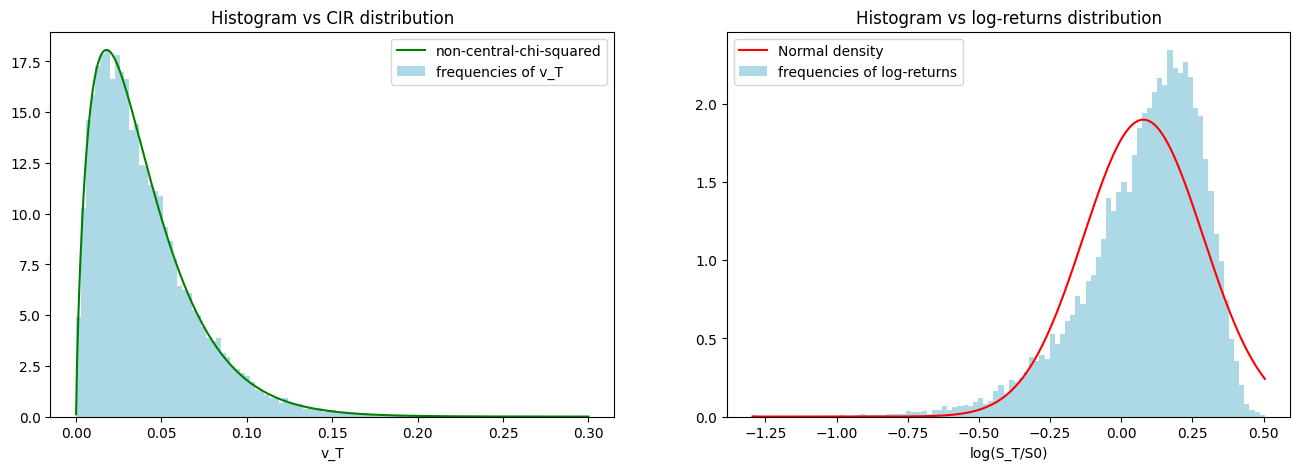

In [31]:
log_R = np.log(S / S0)
x = np.linspace(log_R.min(), log_R.max(), 500)
y = np.linspace(0.00001, 0.3, 500)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(y, ss.ncx2.pdf(y, df, nc, scale=1 / (2 * c)), color="green", label="non-central-chi-squared")
ax1.hist(V, density=True, bins=100, facecolor="LightBlue", label="frequencies of v_T")
ax1.legend()
ax1.set_title("Histogram vs CIR distribution")
ax1.set_xlabel("v_T")

ax2.plot(x, ss.norm.pdf(x, log_R.mean(), log_R.std(ddof=0)), color="r", label="Normal density")
ax2.hist(log_R, density=True, bins=100, facecolor="LightBlue", label="frequencies of log-returns")
ax2.legend()
ax2.set_title("Histogram vs log-returns distribution")
ax2.set_xlabel("log(S_T/S0)")
plt.show()

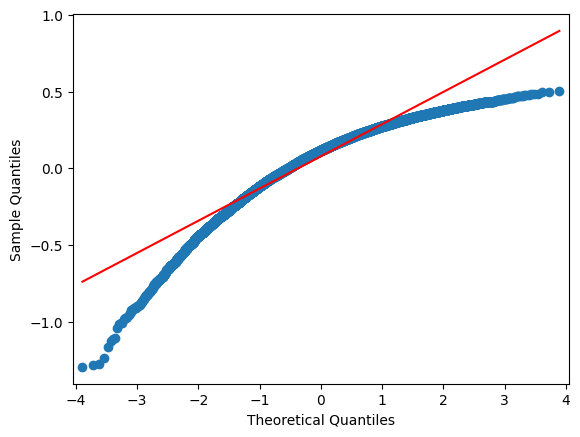

In [32]:
qqplot(log_R, line="s")
plt.show()

The distribution of the log-returns in the Heston model is far from being normal, as can also be observed from the quantile-quantile (q-q) plot.

This characteristic is advantageous because it allows for a better description of the features of empirical distributions obtained from market data.

You can experiment with the correlation parameter $\rho$ to obtain different skewness values in the distribution of log-returns:

- For negative $\rho$, the distribution of log-returns will exhibit negative skewness.
- For positive $\rho$, the distribution of log-returns will exhibit positive skewness.

In [33]:
%%time
S2, _ = Heston_paths(N=20000, paths=20000, T=T, S0=S0, v0=v0, mu=mu, rho=0.9, kappa=kappa, theta=theta, sigma=sigma)
log_R2 = np.log(S2 / S0)

CPU times: user 25.6 s, sys: 6.73 ms, total: 25.6 s
Wall time: 25.7 s


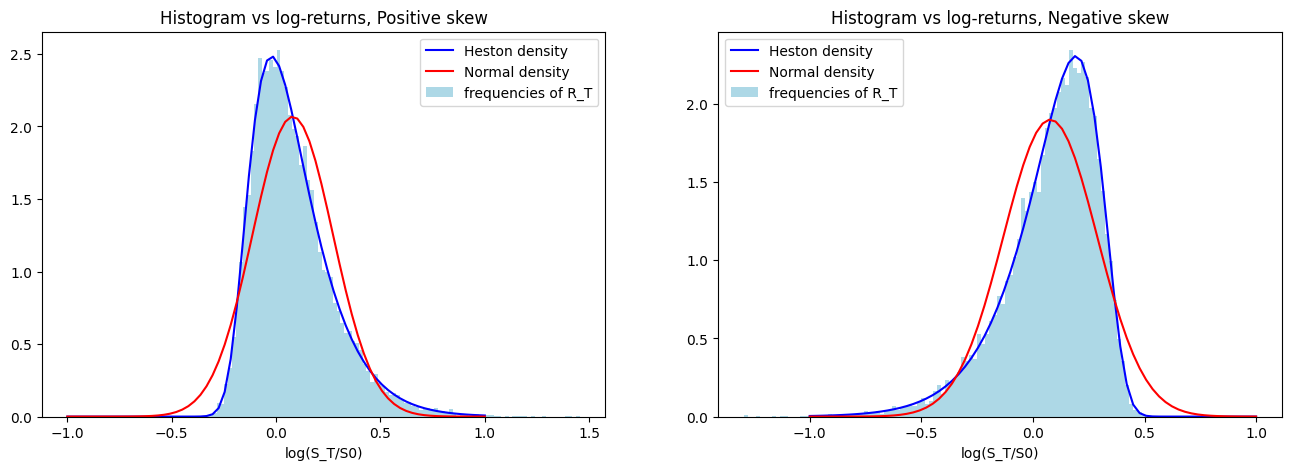

In [34]:
x = np.linspace(-1, 1, 70)

fig = plt.figure(figsize=(16, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(
    x,
    [Heston_pdf(i, t=T, v0=v0, mu=mu, theta=theta, sigma=sigma, kappa=kappa, rho=0.9) for i in x],
    color="blue",
    label="Heston density",
)
ax1.plot(x, ss.norm.pdf(x, log_R2.mean(), log_R2.std(ddof=0)), color="r", label="Normal density")
ax1.hist(log_R2, density=True, bins=100, facecolor="LightBlue", label="frequencies of R_T")
ax1.legend()
ax1.set_title("Histogram vs log-returns, Positive skew")
ax1.set_xlabel("log(S_T/S0)")

ax2.plot(
    x,
    [Heston_pdf(i, t=T, v0=v0, mu=mu, theta=theta, sigma=sigma, kappa=kappa, rho=-0.9) for i in x],
    color="blue",
    label="Heston density",
)
ax2.plot(x, ss.norm.pdf(x, log_R.mean(), log_R.std(ddof=0)), color="r", label="Normal density")
ax2.hist(log_R, density=True, bins=100, facecolor="LightBlue", label="frequencies of R_T")
ax2.legend(loc="upper left")
ax2.set_title("Histogram vs log-returns, Negative skew")
ax2.set_xlabel("log(S_T/S0)")
plt.show()

In [35]:
print("The skewness for rho= -0.9 is: ", ss.skew(log_R))
print("The skewness for rho= +0.9 is: ", ss.skew(log_R2))

The skewness for rho= -0.9 is:  -1.1550880187314148
The skewness for rho= +0.9 is:  1.182044806643254


In the pictures above, we can observe the difference between the Normal distribution and the Heston distribution.

The function `Heston_pdf` is used to implement the Fourier inversion of the Heston characteristic function using the Gil-Pelaez formula. This function allows for the visualization of the probability density function (pdf) of the Heston distribution, highlighting its deviation from the Normal distribution.


<a id='sec3'></a>
# Characteristic Function

The characteristic function (CF) for the Heston model was first presented in the original paper by Heston in 1993 [1].

The Heston CF is highly useful for computing option prices. Other methods, such as Monte Carlo or Partial Differential Equations (PDE), are relatively slow, whereas Fourier inversion (as seen in notebook **1.3**) is significantly faster.

### Issue with the Heston CF

The Heston CF works well for short time durations $T$.    
However, for longer durations, this CF exhibits discontinuities due to the multivalued complex functions (the complex square root and the complex logarithm require a specified [Principal branch](https://en.wikipedia.org/wiki/Principal_branch)).
As a result, numerical integration becomes unstable.

In the significant articles [2] and [3], different (but equivalent) forms of the Heston CF are presented. These CFs consider different [Riemann surfaces](https://en.wikipedia.org/wiki/Riemann_surface) and resolve the problem.

In the following sections, I will demonstrate how the CF proposed by Schoutens (in [2]) performs better than the original Heston CF.     
In these notebooks, all functions that consider the Heston CF are implemented using the CF `cf_Heston_good` proposed by Schoutens.


In [36]:
r = 0.05  # drift
rho = -0.8  # correlation coefficient
kappa = 3  # mean reversion coefficient
theta = 0.1  # long-term mean of the variance
sigma = 0.25  # (Vol of Vol) - Volatility of instantaneous variance
T = 15  # Terminal time
K = 100  # Stike
v0 = 0.08  # spot variance
S0 = 100  # spot stock price
k = np.log(K / S0)  # log moneyness

In [37]:
def cf_Heston(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed in the original paper of Heston (1993)
    """
    xi = kappa - sigma * rho * u * 1j
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
    g1 = (xi + d) / (xi - d)
    cf = np.exp(
        1j * u * mu * t
        + (kappa * theta) / (sigma**2) * ((xi + d) * t - 2 * np.log((1 - g1 * np.exp(d * t)) / (1 - g1)))
        + (v0 / sigma**2) * (xi + d) * (1 - np.exp(d * t)) / (1 - g1 * np.exp(d * t))
    )
    return cf

In [38]:
def cf_Heston_good(u, t, v0, mu, kappa, theta, sigma, rho):
    """
    Heston characteristic function as proposed by Schoutens (2004)
    """
    xi = kappa - sigma * rho * u * 1j
    d = np.sqrt(xi**2 + sigma**2 * (u**2 + 1j * u))
    g1 = (xi + d) / (xi - d)
    g2 = 1 / g1
    cf = np.exp(
        1j * u * mu * t
        + (kappa * theta) / (sigma**2) * ((xi - d) * t - 2 * np.log((1 - g2 * np.exp(-d * t)) / (1 - g2)))
        + (v0 / sigma**2) * (xi - d) * (1 - np.exp(-d * t)) / (1 - g2 * np.exp(-d * t))
    )
    return cf

In [39]:
cf_H_b = partial(cf_Heston, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho)
cf_H_b_good = partial(cf_Heston_good, t=T, v0=v0, mu=r, theta=theta, sigma=sigma, kappa=kappa, rho=rho)

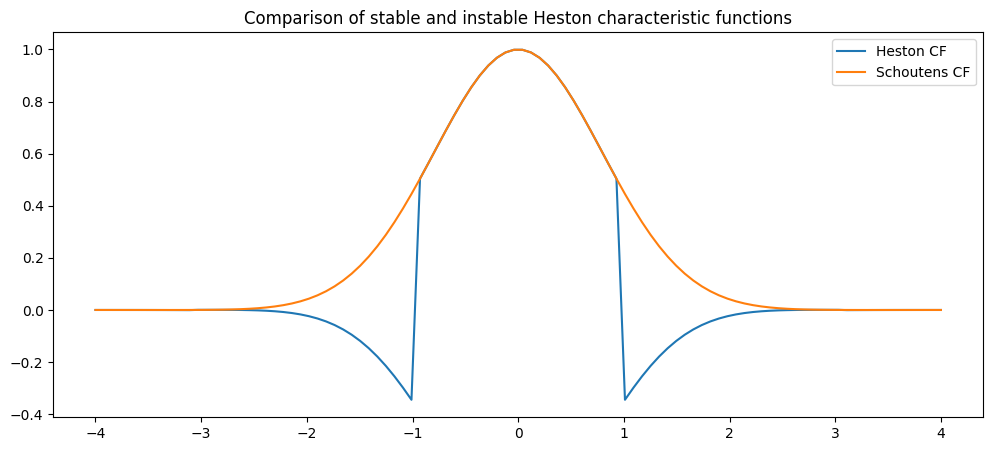

In [40]:
u = np.linspace(-4, 4, 100)

plt.figure(figsize=(12, 5))
plt.plot(u, np.real(cf_H_b(u)), label="Heston CF")
plt.plot(u, np.real(cf_H_b_good(u)), label="Schoutens CF")
plt.title("Comparison of stable and instable Heston characteristic functions")
plt.legend()
plt.show()

<a id='sec3.1'></a>
## Option Pricing

We can compare the values of a European call option computed with the following two pricing methods:

(as usual, we consider the parameters defined above as the *risk-neutral* parameters)

### Monte Carlo


In [41]:
%%time
S, v = Heston_paths(N=20000, paths=20000, T=T, S0=S0, v0=v0, mu=r, rho=rho, kappa=kappa, theta=theta, sigma=sigma)
DiscountedPayoff = np.exp(-r * T) * np.maximum(S - K, 0)
V = np.mean(DiscountedPayoff)
std_err = ss.sem(DiscountedPayoff)
print("Heston Monte Carlo call price: ", V)
print("With standard error: ", std_err)
print("-----------------------------------")

Heston Monte Carlo call price:  64.83115106022484
With standard error:  1.1100688417854128
-----------------------------------
CPU times: user 26.1 s, sys: 112 ms, total: 26.2 s
Wall time: 25.6 s


##### Fourier inversion

In [43]:
%%time
limit_max = 1000  # right limit in the integration
call = S0 * calc_Q1(k, cf_H_b_good, limit_max) - K * np.exp(-r * T) * calc_Q2(k, cf_H_b_good, limit_max)
print("Heston Fourier inversion call price: ", call)
print("-----------------------------------")

Heston Fourier inversion call price:  65.27786862734618
-----------------------------------
CPU times: user 21.8 ms, sys: 1.02 ms, total: 22.8 ms
Wall time: 22.7 ms


## References

[1] Heston, S. L. (1993). "A closed-form solution for options with stochastic volatility and applications to bond and currency options". Review of Financial Studies

[2] Schoutens, W., Simons, E., & Tistaert, J. (2004). "A perfect calibration! Now what?". Wilmott Magazine
[link](https://perswww.kuleuven.be/~u0009713/ScSiTi03.pdf)

[3] Yiran Cui, Sebastian del Baño Rollin, Guido Germano, (2017), "Full and fast calibration of the Heston stochastic volatility model" European Journal of operational research. [link](http://www0.cs.ucl.ac.uk/staff/g.germano/papers/EurJOperRes_2017.pdf)